In [9]:
# Import libraries
import pandas as pd
import numpy as np

In [10]:
# Import data from sensex.csv
df = pd.read_csv('sensex.csv')
df.head()

,Price,Close,High,Low,Open,Volume
0,Date,NaN,NaN,NaN,NaN,NaN
1,1997-07-01,4300.859863,4301.770020,4247.660156,4263.109863,0.0
2,1997-07-02,4333.899902,4395.310059,4295.399902,4302.959961,0.0
3,1997-07-03,4323.459961,4393.290039,4299.970215,4335.790039,0.0
4,1997-07-04,4323.819824,4347.589844,4300.580078,4332.700195,0.0


In [11]:
# Rename the 'Price' column to 'Date' and remove the first row
df = df.rename(columns={'Price': 'Date'})
df = df.iloc[1:]
df.head()

,Date,Close,High,Low,Open,Volume
1,1997-07-01,4300.859863,4301.770020,4247.660156,4263.109863,0.0
2,1997-07-02,4333.899902,4395.310059,4295.399902,4302.959961,0.0
3,1997-07-03,4323.459961,4393.290039,4299.970215,4335.790039,0.0
4,1997-07-04,4323.819824,4347.589844,4300.580078,4332.700195,0.0
5,1997-07-07,4291.450195,4391.009766,4289.490234,4326.810059,0.0


In [12]:
# Convert 'Date' column to datetime objects and set as index
if 'Date' in df.columns:
    df['Date'] = pd.to_datetime(df['Date'])
    df = df.sort_values('Date')
    df.set_index('Date', inplace=True)

print('Dataframe setelah proses kolom Date:')
df.head()

Dataframe setelah proses kolom Date:


,Close,High,Low,Open,Volume
Date,,,,,
1997-07-01,4300.859863,4301.770020,4247.660156,4263.109863,0.0
1997-07-02,4333.899902,4395.310059,4295.399902,4302.959961,0.0
1997-07-03,4323.459961,4393.290039,4299.970215,4335.790039,0.0
1997-07-04,4323.819824,4347.589844,4300.580078,4332.700195,0.0
1997-07-07,4291.450195,4391.009766,4289.490234,4326.810059,0.0


In [13]:
# Calculate daily returns in percentage
df['Daily_Return'] = df['Close'].pct_change()*100

# Define a threshold for a daily crash (e.g., drop more than 5%)
crash_threshold_daily = -5
df['Crash_Daily'] = df['Daily_Return'] <= crash_threshold_daily

### Plot : Sensex Closing Price w/ Crash

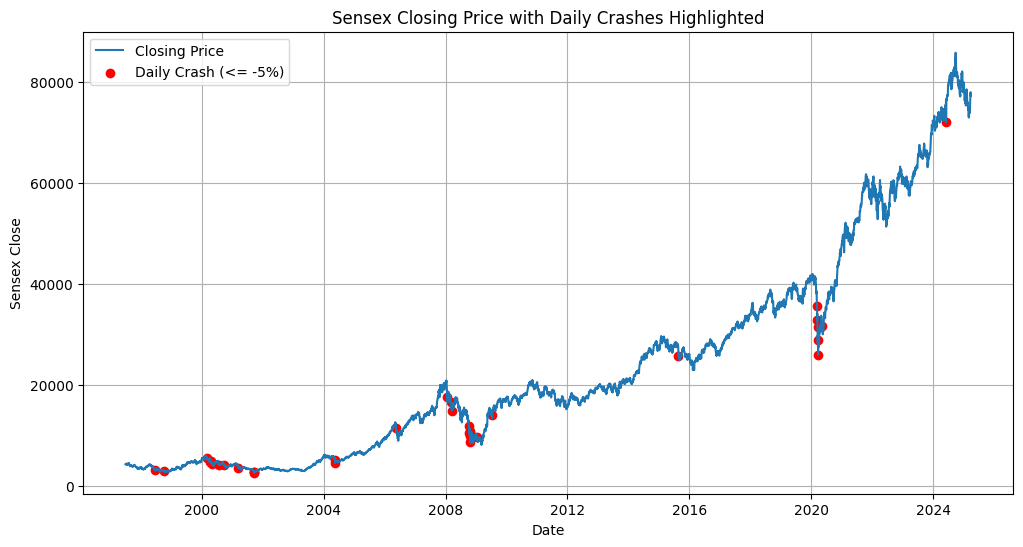

In [14]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))
# Plot the closing price
ax.plot(df.index, df['Close'], label='Closing Price')

# Get dates and prices for crash days
crash_days = df.index[df['Crash_Daily']]
crash_closes = df['Close'][df['Crash_Daily']]

# Scatter plot for daily crashes
ax.scatter(crash_days, crash_closes, color='red', label=f'Daily Crash (<= {crash_threshold_daily}%)')

ax.set_title('Sensex Closing Price with Daily Crashes Highlighted')
ax.set_xlabel('Date')
ax.set_ylabel('Sensex Close')
ax.legend()
plt.grid(True)
plt.show()

'Daily Crash' didefinisikan sebagai hari di mana harga penutupan Sensex turun sebesar 5% atau lebih dibandingkan dengan harga penutupan hari sebelumnya.

Visualisasi ini menampilkan harga penutupan Sensex sepanjang periode historis dengan titik merah yang menyoroti tanggal-tanggal spesifik ketika daily crash ini terjadi.

Plot menunjukkan bahwa meskipun tren keseluruhan Sensex cenderung naik dalam jangka panjang, ada contoh penurunan signifikan dalam satu hari. Daily crash ini muncul sebagai peristiwa terisolasi pada plot, terutama terjadi selama periode turbulensi pasar.

### Plot : Drawdown Analysis

In [15]:
# Calculate cumulative maximum closing price
df['Cumulative_Max'] = df['Close'].cummax()

# Calculate drawdown percentage from cumulative max
df['Drawdown'] = (df['Close'] - df['Cumulative_Max']) / df['Cumulative_Max']*100

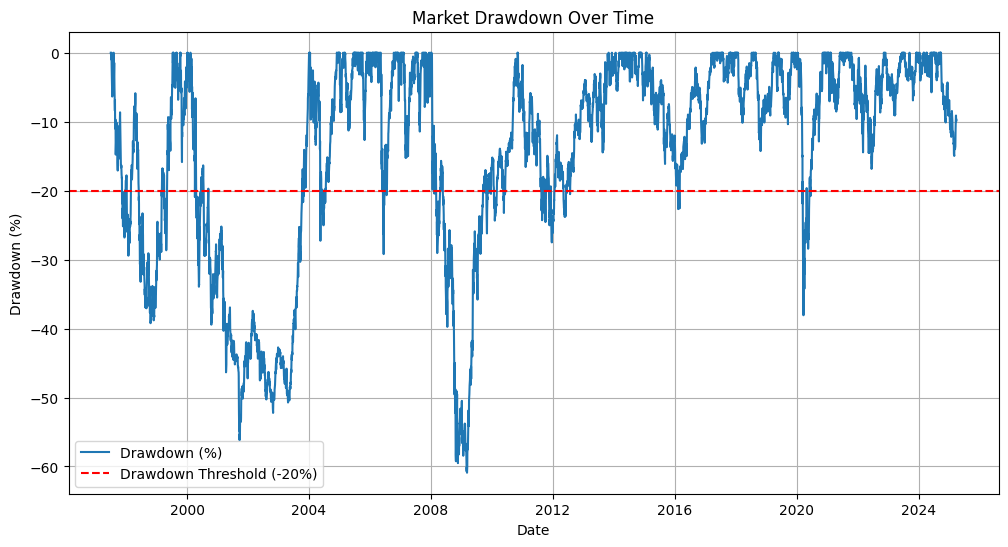

In [16]:
import matplotlib.pyplot as plt

# Define the drawdown threshold
drawdown_threshold = -20

fig, ax = plt.subplots(figsize=(12, 6))
# Plot the drawdown over time
ax.plot(df.index, df['Drawdown'], label='Drawdown (%)')

# Add a horizontal line for the drawdown threshold
ax.axhline(y=drawdown_threshold, color='red', linestyle='--', label=f'Drawdown Threshold ({drawdown_threshold}%)')

ax.set_title('Market Drawdown Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Drawdown (%)')
ax.legend()
plt.grid(True)
plt.show()

'Drawdown' merepresentasikan persentase penurunan Sensex dari puncak historisnya hingga titik waktu tertentu.

Plot Drawdown Pasar dari Waktu ke Waktu secara visual mengindikasikan periode tekanan pasar dengan menunjukkan pergerakan turun yang signifikan pada persentase drawdown. Garis putus-putus merah pada -20% berfungsi sebagai ambang batas, menyoroti periode di mana pasar telah jatuh 20% atau lebih dari puncaknya.
Periode di bawah ambang batas ini merepresentasikan koreksi pasar atau crash pasar yang signifikan.

Plot ini juga menunjukkan periode pemulihan saat garis drawdown bergerak kembali menuju nol, mengindikasikan bahwa pasar mendekati atau melampaui puncak sebelumnya.
Penurunan tajam diikuti oleh tren naik bertahap pada garis drawdown menandakan waktu yang dibutuhkan pasar untuk pulih dari periode tekanan.

In [17]:
# Identify dates where drawdown exceeded the threshold
crash_drawdowns = df[df['Drawdown'] <= drawdown_threshold]
print("Tanggal saat Drawdown melewati threshold:")

# Display the first 10 dates with significant drawdown
print(crash_drawdowns[['Close', 'Cumulative_Max', 'Drawdown']].dropna().head(10))

Tanggal saat Drawdown melewati threshold:
                  Close  Cumulative_Max   Drawdown
Date                                              
1997-11-12  3633.179932      4548.02002 -20.115129
1997-11-13  3554.100098      4548.02002 -21.853904
1997-11-14  3569.770020      4548.02002 -21.509360
1997-11-17  3578.100098      4548.02002 -21.326202
1997-11-18  3518.899902      4548.02002 -22.627871
1997-11-19  3454.649902      4548.02002 -24.040574
1997-11-20  3466.860107      4548.02002 -23.772101
1997-11-21  3523.439941      4548.02002 -22.528047
1997-11-24  3403.070068      4548.02002 -25.174690
1997-11-25  3479.889893      4548.02002 -23.485607


### Plot : Periods of Crashes

In [24]:
# Get dates where drawdown exceeded the threshold
crash_dates = df.index[df['Drawdown'] <= drawdown_threshold]
clusters = []
current_cluster = []

# Cluster consecutive crash dates
for date in crash_dates:
    if not current_cluster:
        current_cluster.append(date)
    else:
        if (date - current_cluster[-1]).days <= 3:
            current_cluster.append(date)
        else:
            clusters.append(current_cluster)
            current_cluster = [date]
if current_cluster:
    clusters.append(current_cluster)

print("Crash clusters berdasarkan drawdown threshold:")
for idx, cluster in enumerate(clusters):
    print(f"Cluster {idx+1}: {cluster[0].date()} to {cluster[-1].date()} (Total days: {len(cluster)})")

Crash clusters berdasarkan drawdown threshold:
Cluster 1: 1997-11-12 to 1997-12-26 (Total days: 31)
Cluster 2: 1997-12-30 to 1997-12-30 (Total days: 1)
Cluster 3: 1998-01-08 to 1998-01-23 (Total days: 12)
Cluster 4: 1998-01-27 to 1998-01-29 (Total days: 3)
Cluster 5: 1998-02-02 to 1998-02-27 (Total days: 19)
Cluster 6: 1998-06-02 to 1998-09-30 (Total days: 86)
Cluster 7: 1998-10-05 to 1998-12-24 (Total days: 56)
Cluster 8: 1998-12-28 to 1998-12-31 (Total days: 4)
Cluster 9: 1999-01-04 to 1999-03-04 (Total days: 40)
Cluster 10: 1999-03-26 to 1999-03-26 (Total days: 1)
Cluster 11: 1999-04-05 to 1999-04-29 (Total days: 18)
Cluster 12: 1999-05-03 to 1999-05-05 (Total days: 3)
Cluster 13: 2000-04-04 to 2000-04-04 (Total days: 1)
Cluster 14: 2000-04-18 to 2000-04-20 (Total days: 3)
Cluster 15: 2000-04-24 to 2000-04-28 (Total days: 5)
Cluster 16: 2000-05-02 to 2000-06-15 (Total days: 33)
Cluster 17: 2000-06-21 to 2000-06-28 (Total days: 5)
Cluster 18: 2000-07-18 to 2000-08-31 (Total days: 32)


Zooming into crash cluster from 1997-11-12 to 1997-12-26


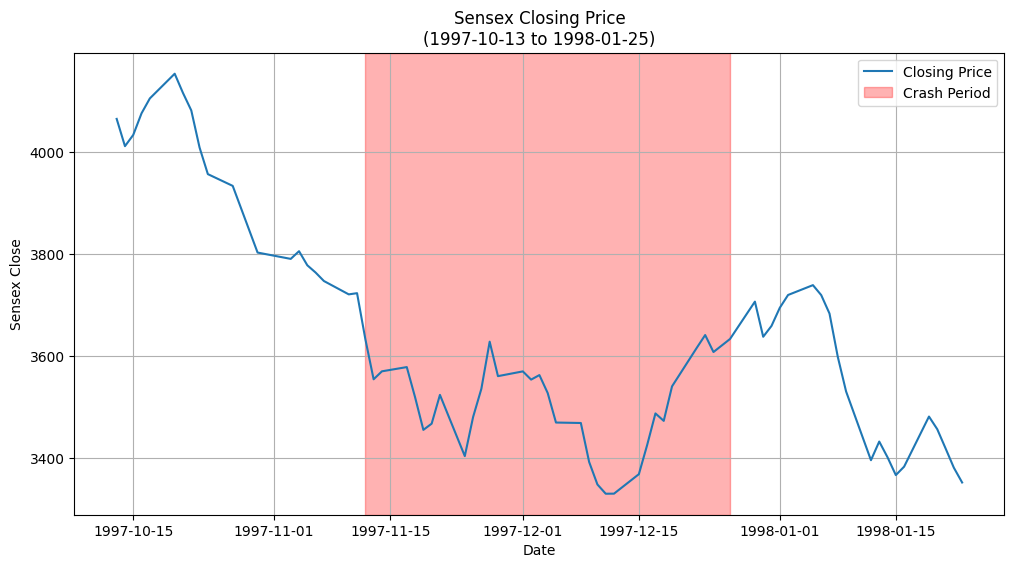

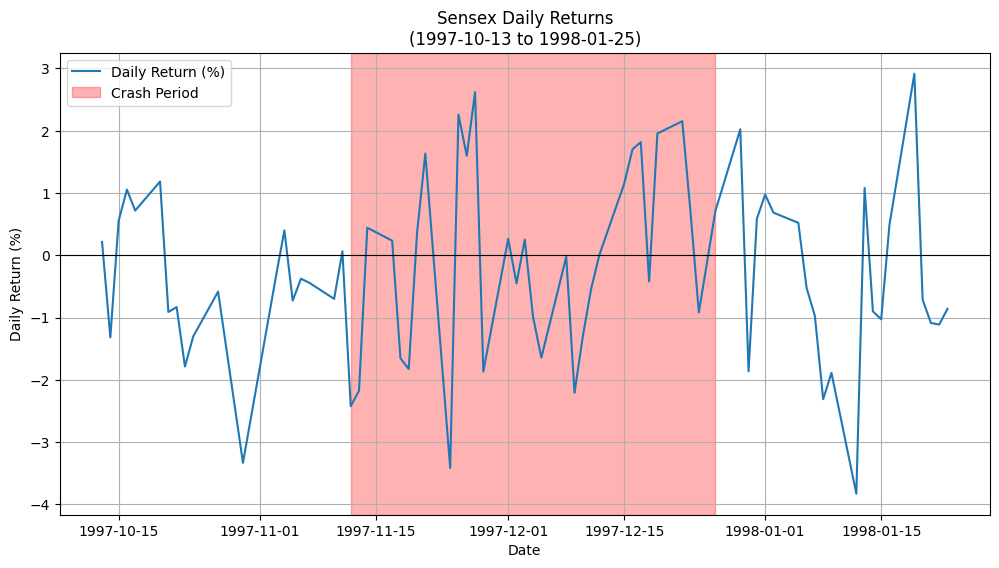

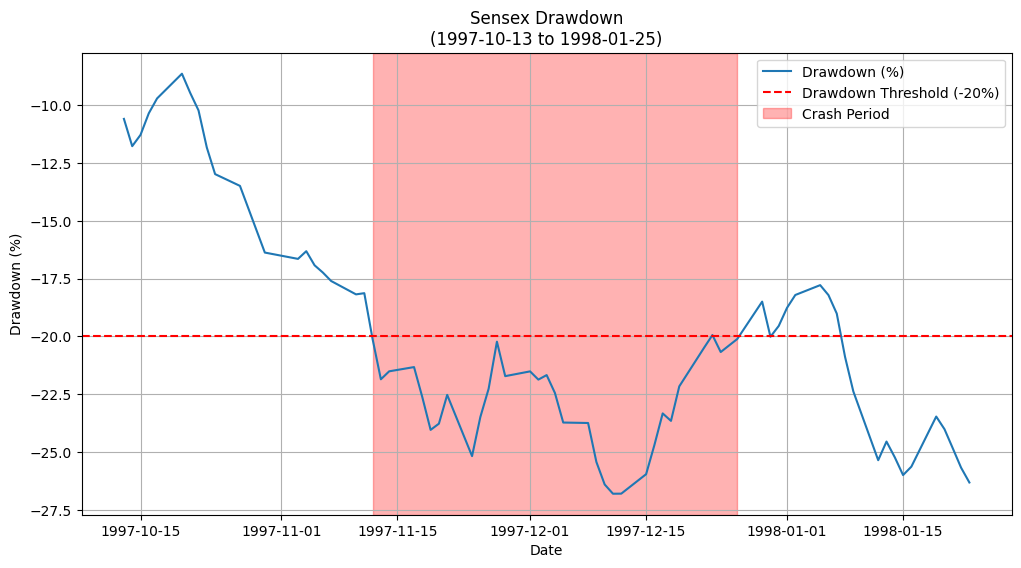

In [19]:
import matplotlib.pyplot as plt

if clusters:
    # Get the first crash cluster
    cluster_start = clusters[0][0]
    cluster_end = clusters[0][-1]
    print(f"\nZooming into crash cluster from {cluster_start.date()} to {cluster_end.date()}")

    # Define zoom window around the crash cluster
    zoom_start = cluster_start - pd.Timedelta(days=30)
    zoom_end = cluster_end + pd.Timedelta(days=30)
    zoom_df = df.loc[zoom_start:zoom_end]

    # Plot closing price with crash period highlighted
    fig_close, ax_close = plt.subplots(figsize=(12, 6))
    ax_close.plot(zoom_df.index, zoom_df['Close'], label='Closing Price')
    ax_close.axvspan(cluster_start, cluster_end, color='red', alpha=0.3, label='Crash Period')
    ax_close.set_title(f'Sensex Closing Price\n({zoom_start.date()} to {zoom_end.date()})')
    ax_close.set_xlabel('Date')
    ax_close.set_ylabel('Sensex Close')
    ax_close.legend()
    plt.grid(True)
    plt.show()

    # Plot daily returns with crash period highlighted
    fig_returns, ax_returns = plt.subplots(figsize=(12, 6))
    ax_returns.plot(zoom_df.index, zoom_df['Daily_Return'], label='Daily Return (%)')
    ax_returns.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    ax_returns.axvspan(cluster_start, cluster_end, color='red', alpha=0.3, label='Crash Period')
    ax_returns.set_title(f'Sensex Daily Returns\n({zoom_start.date()} to {zoom_end.date()})')
    ax_returns.set_xlabel('Date')
    ax_returns.set_ylabel('Daily Return (%)')
    ax_returns.legend()
    plt.grid(True)
    plt.show()

    # Plot drawdown with crash period and threshold highlighted
    fig_drawdown, ax_drawdown = plt.subplots(figsize=(12, 6))
    ax_drawdown.plot(zoom_df.index, zoom_df['Drawdown'], label='Drawdown (%)')
    ax_drawdown.axhline(y=drawdown_threshold, color='red', linestyle='--', label=f'Drawdown Threshold ({drawdown_threshold}%)')
    ax_drawdown.axvspan(cluster_start, cluster_end, color='red', alpha=0.3, label='Crash Period')
    ax_drawdown.set_title(f'Sensex Drawdown\n({zoom_start.date()} to {zoom_end.date()})')
    ax_drawdown.set_xlabel('Date')
    ax_drawdown.set_ylabel('Drawdown (%)')
    ax_drawdown.legend()
    plt.grid(True)
    plt.show()

else:
    print("No crash clusters identified based on the drawdown threshold.")

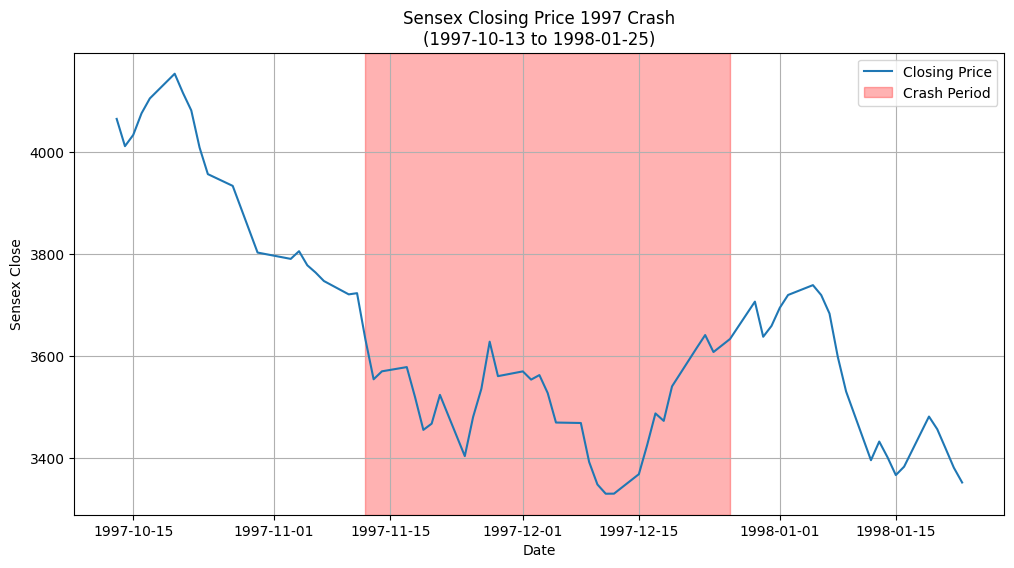

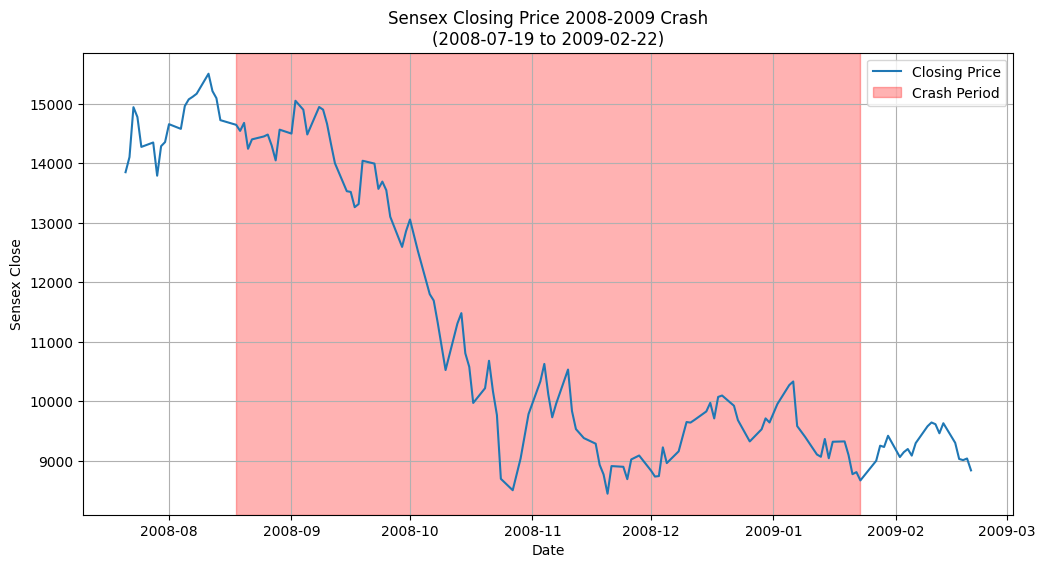

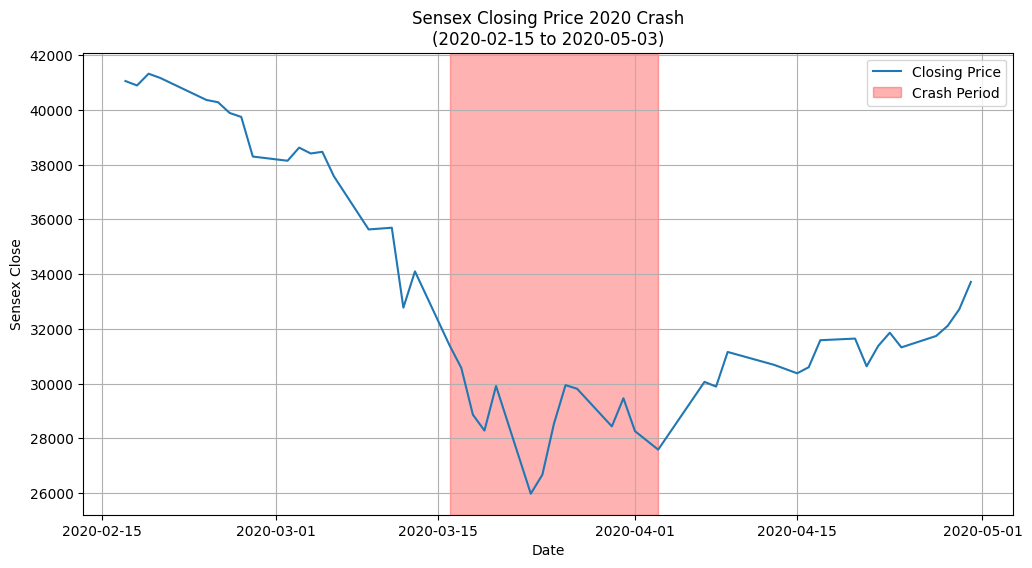

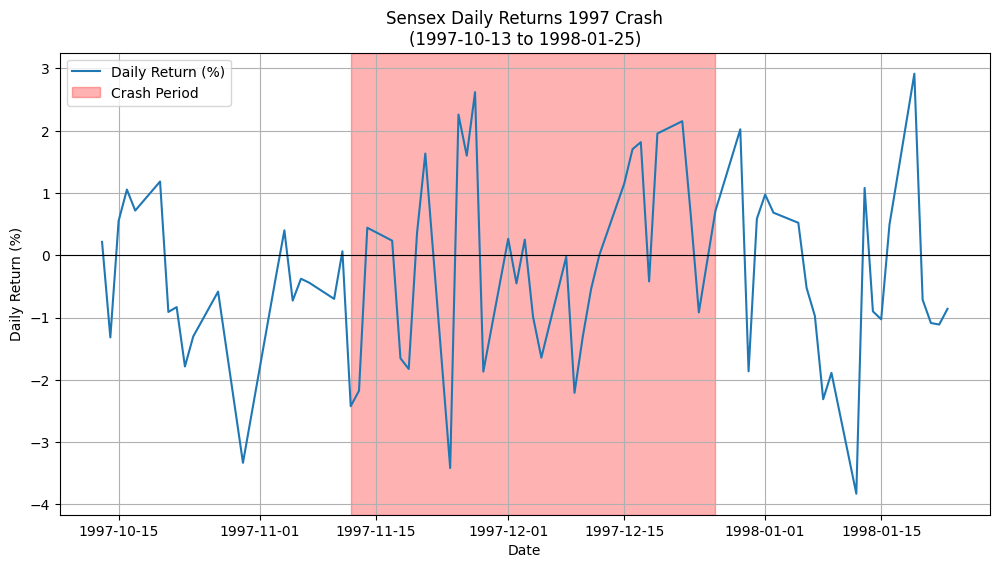

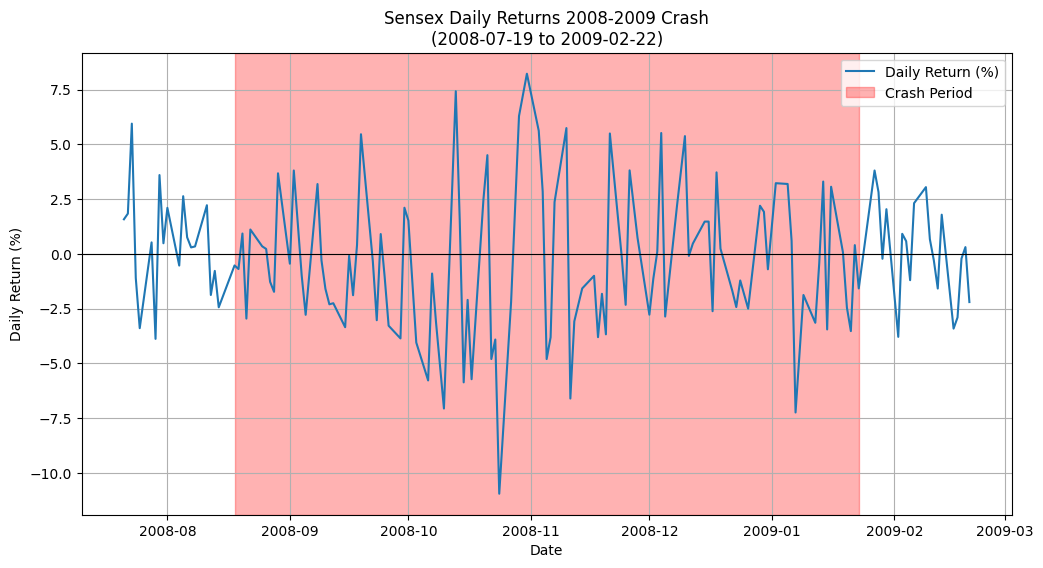

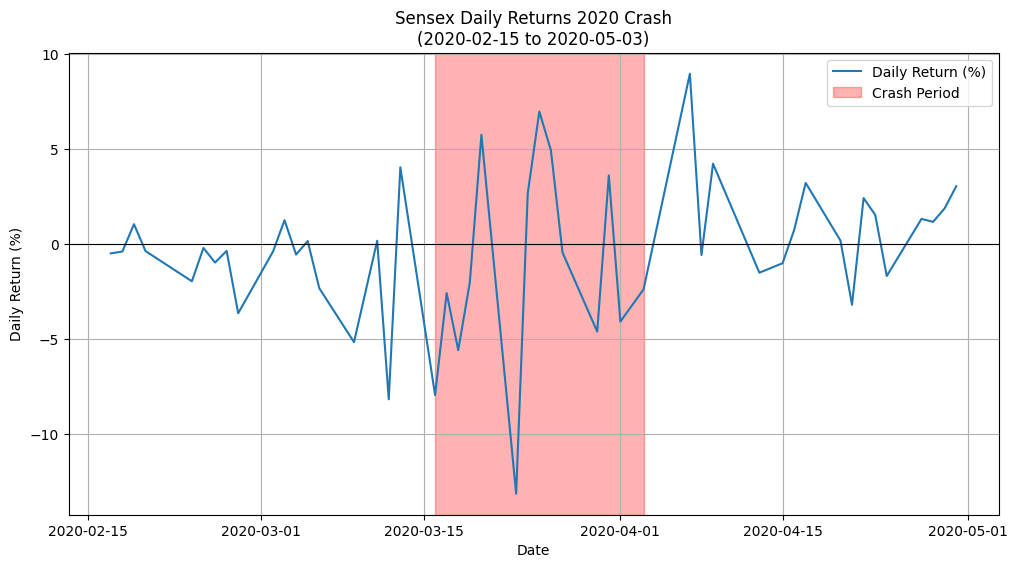

In [20]:
import matplotlib.pyplot as plt

# Define the start and end dates for specific crash clusters
cluster1_start = pd.to_datetime("1997-11-12")
cluster1_end = pd.to_datetime("1997-12-26")

cluster49_start = pd.to_datetime("2008-08-18")
cluster49_end = pd.to_datetime("2009-01-23")

cluster79_start = pd.to_datetime("2020-03-16")
cluster79_end = pd.to_datetime("2020-04-03")

# Function to plot closing price for a given crash period
def plot_crash_period(cluster_start, cluster_end, title_suffix=""):
    zoom_start = cluster_start - pd.Timedelta(days=30)
    zoom_end = cluster_end + pd.Timedelta(days=30)
    zoom_df = df.loc[zoom_start:zoom_end]

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(zoom_df.index, zoom_df['Close'], label='Closing Price')
    ax.axvspan(cluster_start, cluster_end, color='red', alpha=0.3, label='Crash Period')
    ax.set_title(f'Sensex Closing Price {title_suffix}\n({zoom_start.date()} to {zoom_end.date()})')
    ax.set_xlabel('Date')
    ax.set_ylabel('Sensex Close')
    ax.legend()
    plt.grid(True)
    plt.show()

# Function to plot daily returns for a given crash period
def plot_daily_returns(cluster_start, cluster_end, title_suffix=""):
    zoom_start = cluster_start - pd.Timedelta(days=30)
    zoom_end = cluster_end + pd.Timedelta(days=30)
    zoom_df = df.loc[zoom_start:zoom_end]

    fig, ax = plt.subplots(figsize=(12, 6))
    ax.plot(zoom_df.index, zoom_df['Daily_Return'], label='Daily Return (%)')
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.8)
    ax.axvspan(cluster_start, cluster_end, color='red', alpha=0.3, label='Crash Period')
    ax.set_title(f'Sensex Daily Returns {title_suffix}\n({zoom_start.date()} to {zoom_end.date()})')
    ax.set_xlabel('Date')
    ax.set_ylabel('Daily Return (%)')
    ax.legend()
    plt.grid(True)
    plt.show()

# Plot for each specified crash period
plot_crash_period(cluster1_start, cluster1_end, "1997 Crash")
plot_crash_period(cluster49_start, cluster49_end, "2008-2009 Crash")
plot_crash_period(cluster79_start, cluster79_end, "2020 Crash")

# Plot daily returns for each specified crash period
plot_daily_returns(cluster1_start, cluster1_end, "1997 Crash")
plot_daily_returns(cluster49_start, cluster49_end, "2008-2009 Crash")
plot_daily_returns(cluster79_start, cluster79_end, "2020 Crash")

Crash Clusters yang teridentifikasi merepresentasikan periode tekanan pasar yang berkelanjutan di mana Sensex mengalami penurunan signifikan dan berkepanjangan dari puncak sebelumnya, yang didefinisikan oleh drawdown sebesar 20% atau lebih.
Ini bukanlah hanya peristiwa satu hari, melainkan periode koreksi pasar atau pasar beruang.

Plot yang diperbesar untuk periode crash spesifik secara visual mengilustrasikan dampak dari peristiwa-peristiwa ini:
- Plot Harga Penutupan menunjukkan lintasan penurunan pasar yang jelas selama waktu-waktu ini.
- Plot Pengembalian Harian menyoroti peningkatan volatilitas dan frekuensi ayunan harga negatif yang besar selama crash.
- Plot Drawdown jelas menunjukkan kedalaman dan durasi penurunan pasar dari puncaknya, memberikan ukuran visual tingkat keparahan crash.

Membandingkan periode crash yang berbeda (seperti 1997, 2008-2009, dan 2020) melalui plot ini mengungkapkan bahwa meskipun semua crash melibatkan penurunan signifikan dan peningkatan volatilitas, besarnya, durasi, dan kecepatan pemulihannya dapat sangat bervariasi. Misalnya pada crash 2008-2009 (Global Financial Crisis), tampak lebih parah dan berkepanjangan dalam hal drawdown dibandingkan dengan pemulihan yang lebih tajam tetapi lebih cepat terlihat pada crash 2020 (COVID-19).

### Early Warning Signal : Simulating 2025

In [21]:
np.random.seed(42)

# Generate a date range for 2025
dates_2025 = pd.bdate_range(start="2025-01-01", periods=250)

# Generate synthetic daily returns with different characteristics
daily_returns = np.zeros(250)
daily_returns[:150] = np.random.normal(loc=0.0005, scale=0.01, size=150)
daily_returns[150:200] = np.random.normal(loc=-0.008, scale=0.025, size=50)
daily_returns[200:] = np.random.normal(loc=0.0005, scale=0.01, size=50)

# Calculate synthetic prices based on returns
prices = [30000]
for ret in daily_returns:
    prices.append(prices[-1]*(1+ret))
prices = prices[1:]

# Create a DataFrame for the 2025 simulation
df_2025 = pd.DataFrame({
    'Date': dates_2025,
    'Close': prices,
    'Daily_Return': daily_returns * 100
})
df_2025.set_index('Date', inplace=True)

In [25]:
# Calculate rolling mean and standard deviation of daily returns
df_2025['Rolling_Mean_Return'] = df_2025['Daily_Return'].rolling(window=10).mean()
df_2025['Rolling_Volatility'] = df_2025['Daily_Return'].rolling(window=10).std()

# Define the warning condition based on rolling metrics
warning_condition = (df_2025['Rolling_Mean_Return'] < -0.5) & (df_2025['Rolling_Volatility'] > 2)
# Identify dates with warning signals
df_2025['Warning'] = warning_condition

# Filter for warning dates
warnings_df = df_2025[df_2025['Warning']]
print("Early Warning Signals 2025:")
# Display warning signal data
print(warnings_df[['Close', 'Daily_Return', 'Rolling_Mean_Return', 'Rolling_Volatility']].head(15))

Early Warning Signals 2025:
                   Close  Daily_Return  Rolling_Mean_Return  \
Date                                                          
2025-08-13  26293.754799     -3.236704            -0.723106   
2025-08-14  26600.790000      1.167712            -0.612947   
2025-08-29  25310.851435     -0.992754            -0.676806   
2025-09-02  25296.816487     -0.108273            -0.558018   
2025-09-04  25420.955891     -0.767495            -0.656682   
2025-09-23  23735.864103     -4.587118            -1.372651   
2025-09-25  23593.214467      1.340997            -1.212308   
2025-09-29  22609.672636     -3.914347            -1.323114   
2025-09-30  22526.684356     -0.367048            -1.223953   

            Rolling_Volatility  
Date                            
2025-08-13            2.316762  
2025-08-14            2.383681  
2025-08-29            2.373521  
2025-09-02            2.146429  
2025-09-04            2.130037  
2025-09-23            2.003797  
2025-09-25    

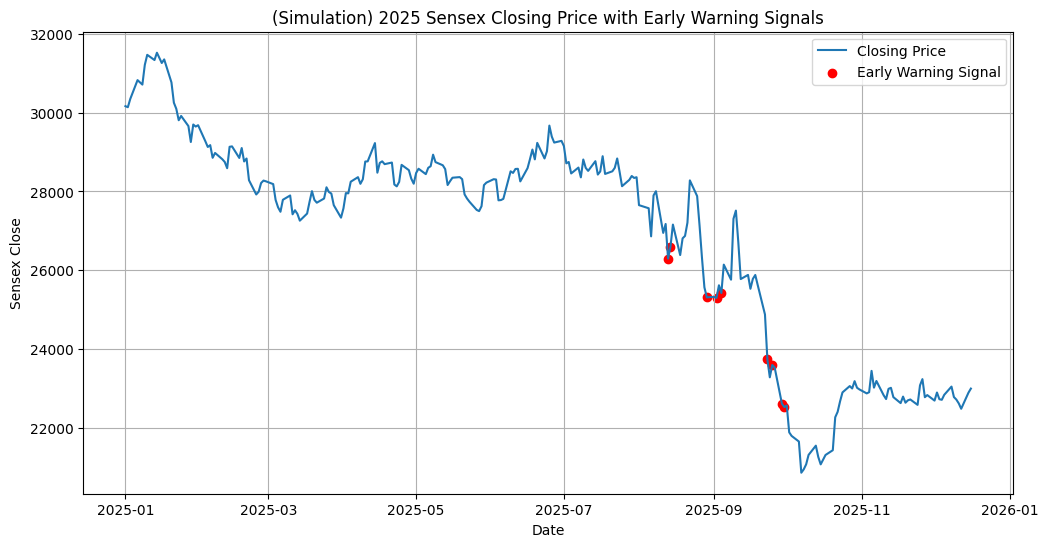

In [23]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))

# Plot the synthetic closing price
ax.plot(df_2025.index, df_2025['Close'], label='Closing Price')

# Get dates and prices for warning signals
warning_dates = df_2025.index[df_2025['Warning']]
warning_closes = df_2025['Close'][df_2025['Warning']]

# Scatter plot for early warning signals
ax.scatter(warning_dates, warning_closes, color='red', label='Early Warning Signal')

ax.set_title('(Simulation) 2025 Sensex Closing Price with Early Warning Signals')
ax.set_xlabel('Date')
ax.set_ylabel('Sensex Close')
ax.legend()
plt.grid(True)
plt.show()

Simulasi ini mencakup fase dari sekitar pertengahan Agustus hingga akhir September di mana pengembalian harian sintetis memiliki rata-rata negatif dan volatilitas lebih tinggi, meniru potensi penurunan pasar.

Sinyal peringatan dini, yang disorot oleh penanda merah pada plot, dipicu ketika rata-rata pengembalian harian rolling 10 hari turun di bawah -0.5% dan volatilitas rolling 10 hari melebihi 2%.

Dalam konteks potensi penurunan pasar di masa depan, sinyal-sinyal ini merepresentasikan periode di mana pasar menunjukkan kombinasi kinerja negatif terkini dan peningkatan ketidakstabilan, yang dapat berfungsi sebagai peringatan bagi investor untuk berhati-hati atau mempertimbangkan strategi manajemen risiko.
